# Classifying Global Urban Bus Services using Publicly-Available Routing Data

Authors: [Ed Manley](https://environment.leeds.ac.uk/geography/staff/9293/professor-ed-manley) and [Nick Malleson](http://nickmalleson.co.uk/)

This notebook contains the analysis used in our 2020 GISRUK abstract: '_Classifying Global Urban Bus Services using Publicly-Available Routing Data_'. The abstract is available at [here](../abstract/Buses.pdf).

## Initialisation

In [1]:
import pandas as pd
#from sqlalchemy import create_engine
import folium
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn import preprocessing
from sklearn import metrics

 
%matplotlib inline
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
plt.style.use('seaborn-dark')

## Read the route metrics data

Note that the original data were extracted from XXXX, stored in a local database, and then used to create the CSV files that are read below.

In [2]:
# import data on routes, cities, and subset
route_metrics = pd.read_csv('new_route_metrics.csv')
city_metrics = pd.read_csv('all_city_metrics.csv')

# First subset is all routes except for very short ones. These are used to generat clusters.
subset_cities = []
with open('subset_cities.txt') as file:
    for line in file: 
        line = line.strip() 
        subset_cities.append(line)
subset_cities = pd.Series(subset_cities, name='city')
subset_cities = subset_cities.to_frame()

# Second subset is even smaller, just 'major' cities. Mostly used for the discussion because otherwise there is too much to discuss.
subset_cities2 = []
with open('subset_cities2.txt') as file:
    for line in file: 
        line = line.strip() 
        subset_cities2.append(line)
subset_cities2 = pd.Series(subset_cities2, name='city').to_frame()

In [3]:
# merge all datasets
route_city_metrics = route_metrics.merge(city_metrics,left_on="location", right_on='city')
route_city_metrics = route_city_metrics.set_index('city').join(subset_cities.set_index('city'), on='city', how='right')
route_city_metrics = route_city_metrics.reset_index(drop=True)

In [4]:
len(route_city_metrics)

15130

In [5]:
# filters
route_city_metrics = route_city_metrics[route_city_metrics['route_length'] < 100]
print(len(route_city_metrics))
route_city_metrics = route_city_metrics.loc[(route_city_metrics['sinuocity'] < 50) & (route_city_metrics['sinuocity'] > 1.001)]
print(len(route_city_metrics))

14979
13900


In [6]:
# normalise
# selling point - these measures can be used to describe all bus routes
# connectivity?
# circularity?
route_city_metrics['norm_length'] = route_city_metrics['route_length'].div(route_city_metrics.groupby('location')['route_length'].transform('max'))
route_city_metrics['norm_stops'] = route_city_metrics['route_length'] / route_city_metrics['stops']
route_city_metrics['city_norm_curve'] = route_city_metrics['rel_entropy'] * route_city_metrics['norm_curve']
route_city_metrics['norm_turns'] = route_city_metrics['major_turns'] / route_city_metrics['route_length']

We used data from the following cities and countries:

In [7]:
route_city_metrics['country'] = route_city_metrics['city'].apply(lambda x: x.split(',')[-1].strip() )
countries = route_city_metrics['country']
print("{} countries: {}".format(len(countries.unique()), countries.unique()))

cities = route_city_metrics['city'].apply(lambda x: x.split(',')[0].strip() )
print("{} cities: {}".format(len(cities.unique()), cities.unique()))

19 countries: ['USA' 'Austria' 'Germany' 'Canada' 'Russia' 'Czechia' 'Ireland' 'Spain'
 'Italy' 'Finland' 'Poland' 'Lithuania' 'France' 'Belgium' 'Australia'
 'Latvia' 'New Zealand' 'Mexico' 'Hungary']
95 cities: ['San Francisco' 'Orlando' 'Tucson' 'Denver' 'Boise' 'Vienna' 'New York'
 'Washington' 'Seattle' 'Aachen' 'London' 'Regina' 'St Petersburg'
 'Prague' 'Dublin' 'Bakersfield' 'Eugene' 'Portland' 'Madrid' 'Florence'
 'Helsinki' 'Tampere' 'Warsaw' 'Valencia' 'Los Angeles' 'Turin' 'Bilbao'
 'Kaunas' 'Vilnius' 'El Paso' 'Boston' 'Nancy' 'Toulouse' 'Grenoble'
 'Toronto' 'Rome' 'Palermo' 'Riverside' 'Brussels' 'Oklahoma City'
 'Melbourne VIC' 'Atlanta' 'Raleigh' 'Durham' 'Kansas City' 'Edmonton'
 'Providence' 'Stockton' 'Milan' 'New Orleans' 'Rīga' 'Jacksonville'
 'Hartford' 'Detroit' 'Pittsburgh' 'Saskatoon' 'Philadelphia' 'Calgary'
 'Buffalo' 'Tampa' 'Nashville' 'Columbus' 'Cleveland' 'San Diego'
 'Minneapolis' 'Chicago' 'Sacramento' 'Montreal' 'Auckland' 'Oakland'
 'Queens' 'Bronx'

There is an over-representation of cities in the United States:

In [8]:
print(route_city_metrics.pivot_table(index=['country'], aggfunc='count')['Unnamed: 0'].
      sort_values(axis=0,ascending=False).to_latex())

\begin{tabular}{lr}
\toprule
{} &  Unnamed: 0 \\
country     &             \\
\midrule
USA         &        4601 \\
Australia   &        1980 \\
Canada      &        1789 \\
Italy       &         853 \\
New Zealand &         777 \\
Russia      &         709 \\
Finland     &         575 \\
Hungary     &         365 \\
Poland      &         356 \\
Austria     &         354 \\
Czechia     &         328 \\
Spain       &         282 \\
Lithuania   &         182 \\
France      &         175 \\
Germany     &         172 \\
Mexico      &         119 \\
Ireland     &         106 \\
Belgium     &          95 \\
Latvia      &          82 \\
\bottomrule
\end{tabular}



## Analysis

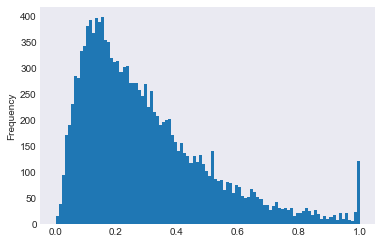

In [9]:
# some plots
route_city_metrics['norm_length'].plot.hist(bins=100);

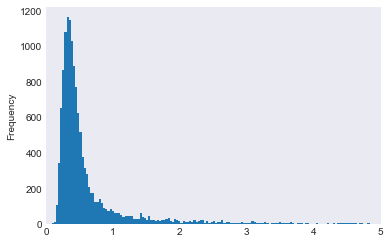

In [10]:
route_city_metrics['norm_stops'].plot.hist(bins=1000, xlim=(0,5));

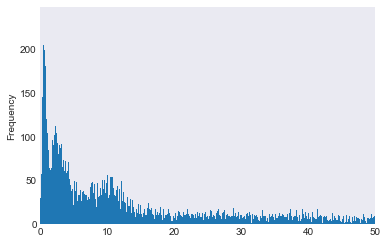

In [11]:
route_city_metrics['city_norm_curve'].loc[route_city_metrics['city_norm_curve'] < 100].plot.hist(bins=1000, xlim=(0,50));

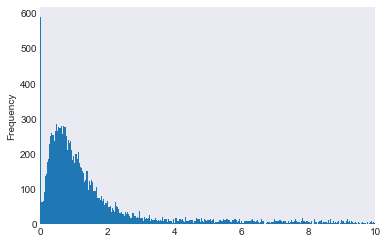

In [12]:
route_city_metrics['norm_turns'].plot.hist(bins=1000, xlim=(0,10));

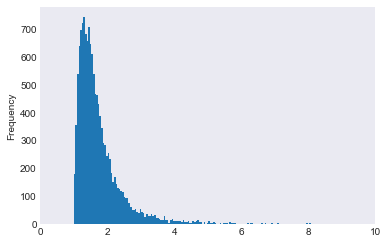

In [13]:
route_city_metrics['sinuocity'].loc[route_city_metrics['sinuocity'] < 100].plot.hist(bins=1000, xlim=(0,10))

## Clusters

### Clusters for all Routes

First create Silhouette plots so we know how many clusters to choose

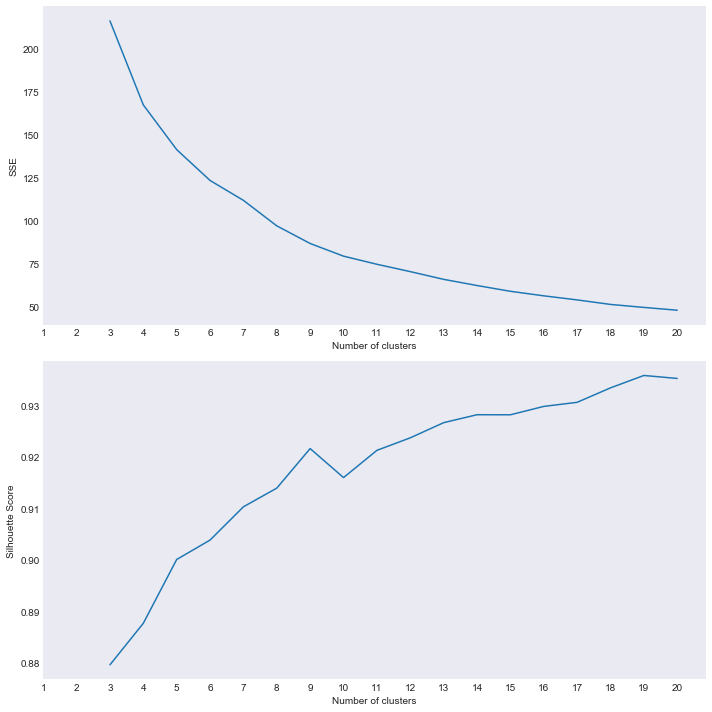

In [14]:
fig = plt.figure(figsize=(10,10))
ss= fig.add_subplot(2,1,1)
si = fig.add_subplot(2,1,2)

n_clusters = 3

sse = {}
sil = {}

while n_clusters <= 20:
    
    # attributes = ['norm_length', 'norm_stops', 'norm_curve', 'sinuocity'] # normalised features
    attributes = ['route_length','norm_stops','sinuocity','city_norm_curve','norm_turns']
    clus_data_raw = route_city_metrics[attributes]

    min_max_scaler = preprocessing.MinMaxScaler()
    np_scaled = min_max_scaler.fit_transform(clus_data_raw)        
    clus_data = pd.DataFrame(np_scaled, columns=attributes)

    clus_data = clus_data.set_index(route_city_metrics.index)

    clusterer = KMeans(n_clusters=n_clusters)
    clusterer.fit(clus_data)

    labels = clusterer.predict(clus_data)    
    clus_data['label'] = labels
    
    sil[n_clusters] = metrics.silhouette_score(clus_data, labels, metric='euclidean')
    sse[n_clusters] = clusterer.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

    n_clusters += 1

ss.plot(list(sse.keys()), list(sse.values()))
si.plot(list(sil.keys()), list(sil.values()))

    
# elbow plot
ss.set_xlabel("Number of clusters")
ss.set_ylabel("SSE")

si.set_xlabel("Number of clusters")
si.set_ylabel("Silhouette Score")

si.set_xticks( range(1, 21))
ss.set_xticks( range(1, 21))
plt.tight_layout()
plt.show()



5 clusters is chosen as SSE curve plateaus. Good Silhouette scores (near 1) indicate high differentaition.

Plots for the GISRUK abstract

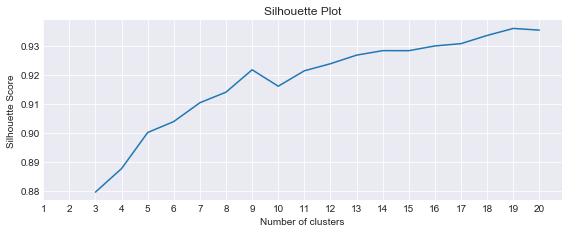

In [15]:
fig = plt.figure(figsize=(8,6))
si = fig.add_subplot(2,1,2)

si.plot(list(sil.keys()), list(sil.values()))
si.set_xlabel("Number of clusters")
si.set_ylabel("Silhouette Score")
si.set_title("Silhouette Plot")
si.set_xticks( range(1, 21))
si.grid(True)
fig.tight_layout()
fig.savefig(fname="silhouette.pdf", bbox_inches='tight')
fig.savefig(fname="../abstract/figures/silhouette.pdf", bbox_inches='tight')
plt.show()

### Clusters for all cities

In [16]:
### CREATING CLUSTERS FOR ALL CITIES
            
# setup for clustering 
n_clusters = 5

# attributes = ['norm_length', 'norm_stops', 'norm_curve', 'sinuocity'] # normalised features
attributes = ['route_length','norm_stops','sinuocity','city_norm_curve','norm_turns']
clus_data_raw = route_city_metrics[attributes]

min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(clus_data_raw)        
clus_data = pd.DataFrame(np_scaled, columns=attributes)

clus_data = clus_data.set_index(route_city_metrics.index)

clusterer = KMeans(n_clusters=n_clusters)
#clusterer = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=2434533)
clusterer.fit(clus_data)

labels = clusterer.predict(clus_data)
        
clus_data['label'] = labels
        
# s_filename = '/Users/edmanley/Dropbox/bus_analysis/global_routes/clusters/all_cities/km_labels_%s_stats.txt' % (n_clusters)
# stats = open(s_filename, 'w')
label_count = 0
while label_count < n_clusters:
    subset = clus_data.loc[clus_data.label == label_count]
    subset = subset[attributes]
    print('CLUSTER ' + str(label_count))
    print(str(subset.describe()))
    
#     stats.write('CLUSTER ' + str(label_count) + '\n')
#     stats.write(str(subset.describe()) + '\n')
#     stats.write('\n')
    label_count += 1
# stats.close()

# fname = '/Users/edmanley/Dropbox/bus_analysis/global_routes/clusters/cities/km_%s_res.txt' % (n_clusters)
# clus_data.to_csv(fname, ',')



CLUSTER 0
       route_length   norm_stops    sinuocity  city_norm_curve   norm_turns
count   7825.000000  7825.000000  7825.000000      7825.000000  7825.000000
mean       0.104222     0.015644     0.019318         0.023994     0.034918
std        0.043123     0.021309     0.044659         0.031570     0.024504
min        0.000000     0.000000     0.000000         0.000017     0.000000
25%        0.071303     0.007381     0.006527         0.002761     0.017409
50%        0.104049     0.009916     0.011707         0.010019     0.030010
75%        0.138546     0.014498     0.020719         0.034158     0.047023
max        0.188035     0.397425     1.000000         0.188071     0.140195
CLUSTER 1
       route_length  norm_stops   sinuocity  city_norm_curve  norm_turns
count    502.000000  502.000000  502.000000       502.000000  502.000000
mean       0.126842    0.011573    0.025889         0.284350    0.148595
std        0.076463    0.014506    0.061564         0.151190    0.098806
min 

Also look at the average values across all routes; this tells you whether a particular cluster has a higher or lower value for a variable than the mean.

In [30]:
clus_data.describe()

,route_length,norm_stops,sinuocity,city_norm_curve,norm_turns,label
count,13900.000000,13900.000000,13900.000000,13900.000000,13900.000000,13900.000000
mean,0.170690,0.025035,0.018477,0.034382,0.054438,1.661295
std,0.129515,0.048571,0.039753,0.064852,0.069830,0.859484
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.088069,0.008352,0.006469,0.003264,0.015896,1.000000
50%,0.137038,0.011583,0.011600,0.011381,0.029844,2.000000
75%,0.213730,0.019058,0.020119,0.039644,0.056378,2.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000


In [17]:
clus_data.groupby(by='label')['route_length'].count().sort_values()

label
1     502
4     574
2    1357
3    3642
0    7825
Name: route_length, dtype: int64

In [21]:
# cluster summary stats
for i in range(n_clusters):
    print(i,"\n",clus_data[['route_length','norm_stops','city_norm_curve','norm_turns','sinuocity']].
          loc[clus_data['label'] == i].mean())


0 
 route_length       0.104222
norm_stops         0.015644
city_norm_curve    0.023994
norm_turns         0.034918
sinuocity          0.019318
dtype: float64
1 
 route_length       0.126842
norm_stops         0.011573
city_norm_curve    0.284350
norm_turns         0.148595
sinuocity          0.025889
dtype: float64
2 
 route_length       0.128041
norm_stops         0.012481
city_norm_curve    0.024452
norm_turns         0.222455
sinuocity          0.021422
dtype: float64
3 
 route_length       0.266411
norm_stops         0.033161
city_norm_curve    0.027691
norm_turns         0.026544
sinuocity          0.015867
dtype: float64
4 
 route_length       0.608646
norm_stops         0.142950
city_norm_curve    0.023320
norm_turns         0.017960
sinuocity          0.010115
dtype: float64


Cluster profiles:

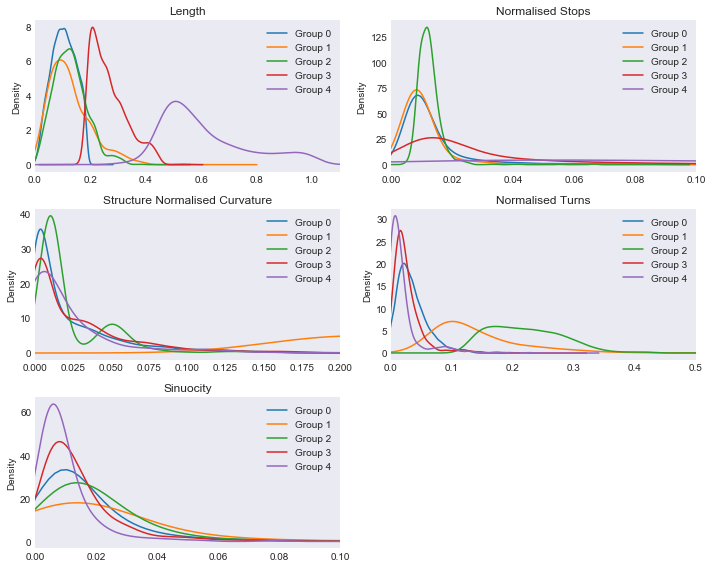

In [79]:
fig = plt.figure(figsize=(10,8))
length= fig.add_subplot(3,2,1)
norm_stops = fig.add_subplot(3,2,2)
city_norm_curve = fig.add_subplot(3,2,3)
norm_turns = fig.add_subplot(3,2,4)
sinuocity = fig.add_subplot(3,2,5)

length.set_title('Length')
norm_stops.set_title('Normalised Stops')
city_norm_curve.set_title('Structure Normalised Curvature')
norm_turns.set_title('Normalised Turns')
sinuocity.set_title('Sinuocity')

#legend = ['Group 0', 'Group 1','Group 2','Group 3','Group 4' ]#,'Group 5'] # 'Group 6', 'Group 7', 'Group 8', 'Group 9']
legend = ['Group '+str(i) for i in range(n_clusters)]

for variable_name, legend_object, _xlim in [('route_length',length,[0,1.1]), ('norm_stops', norm_stops, [0,0.1]), \
                                            ('city_norm_curve', city_norm_curve,[0,0.2]), ('norm_turns',norm_turns,[0,0.5]),\
                                            ('sinuocity',sinuocity,[0,0.1]) ]:
    
    for i in range(n_clusters):
        clus_data[[variable_name]].loc[clus_data['label'] == i].plot.kde(label='Group '+str(i),ax=legend_object)
        
    legend_object.legend(legend)
    legend_object.set_xlim(_xlim)
    


plt.tight_layout()
plt.show()


fig.savefig(fname="cluster_profiles.pdf", bbox_inches='tight')
fig.savefig(fname="../abstract/figures/cluster_profiles.pdf", bbox_inches='tight')

In [23]:
# rejoin data with cluster labels
route_city_clusters = pd.concat([clus_data, route_city_metrics], axis=1)

In [24]:
prop_clusters = route_city_clusters.pivot_table(index=['location'], columns=['label'], 
                                                values=['city'], aggfunc='count')
prop_clusters = prop_clusters.fillna(0)
prop_clusters = prop_clusters.div(prop_clusters.sum(1), axis=0)
prop_clusters


city                                        
label                                         0         1         2         3         4
location                                                                               
Aachen, Germany                        0.744186  0.000000  0.017442  0.232558  0.005814
Adelaide SA, Australia                 0.638514  0.003378  0.000000  0.354730  0.003378
Atlanta, GA, USA                       0.540000  0.013333  0.000000  0.266667  0.180000
Auckland, New Zealand                  0.070605  0.000000  0.812680  0.113833  0.002882
Austin, TX, USA                        0.617647  0.000000  0.000000  0.333333  0.049020
Bakersfield, CA, USA                   0.172414  0.000000  0.000000  0.482759  0.344828
Bilbao, Biscay, Spain                  0.233333  0.000000  0.200000  0.466667  0.100000
Boise, ID, USA                         0.838710  0.000000  0.000000  0.064516  0.096774
Boston, MA, USA                        0.813084  0.000000  0.000000  0.144860  0.042056
Brisbane QLD, Australia                0.483936  0.000000  0.000000  0.405622  0.110442
Bronx, NY, USA                         1.000000  0.000000  0.000000  0.000000  0.000000
Brooklyn, NY, USA                      0.909091  0.000000  0.000000  0.090909  0.000000
Brussels, Belgium                      1.000000  0.000000  0.000000  0.000000  0.000000
Budapest, Hungary                      0.123288  0.000000  0.849315  0.027397  0.000000
Buffalo, NY, USA                       0.000000  0.714286  0.000000  0.142857  0.142857
Calgary, AB, Canada                    0.705882  0.011765  0.000000  0.282353  0.000000
Canberra ACT, Australia                0.500000  0.000000  0.000000  0.445652  0.054348
Chicago, IL, USA                       0.195652  0.760870  0.000000  0.043478  0.000000
Christchurch, New Zealand              0.391304  0.000000  0.000000  0.608696  0.000000
Cleveland, OH, USA                     0.519231  0.000000  0.000000  0.480769  0.000000
Columbus, OH, USA                      0.255814  0.000000  0.000000  0.744186  0.000000
Dallas, TX, USA                        0.596273  0.031056  0.000000  0.354037  0.018634
Denver, CO, USA                        0.130435  0.422360  0.006211  0.279503  0.161491
Detroit, MI, USA                       0.375000  0.000000  0.000000  0.625000  0.000000
Dublin, Ireland                        0.405660  0.000000  0.000000  0.575472  0.018868
Durham, NC, USA                        0.575758  0.000000  0.000000  0.333333  0.090909
Edmonton, AB, Canada                   0.743590  0.102564  0.000000  0.145299  0.008547
El Paso, TX, USA                       0.683673  0.000000  0.000000  0.295918  0.020408
Eugene, OR, USA                        0.187500  0.687500  0.000000  0.125000  0.000000
Florence, Italy                        0.952381  0.000000  0.023810  0.023810  0.000000
Fort Lauderdale, FL, USA               0.061224  0.020408  0.000000  0.836735  0.081633
Grenoble, France                       0.921569  0.000000  0.000000  0.078431  0.000000
Halifax, NS, Canada                    0.795918  0.000000  0.000000  0.204082  0.000000
Hamilton, ON, Canada                   0.852941  0.058824  0.000000  0.088235  0.000000
Hartford, CT, USA                      0.722689  0.000000  0.000000  0.210084  0.067227
Helsinki, Finland                      0.589958  0.000000  0.002092  0.361925  0.046025
Honolulu, HI, USA                      0.421053  0.000000  0.000000  0.484211  0.094737
Houston, TX, USA                       0.289256  0.000000  0.000000  0.619835  0.090909
Jacksonville, FL, USA                  0.480769  0.000000  0.000000  0.500000  0.019231
Kansas City, MO, USA                   0.370370  0.055556  0.000000  0.500000  0.074074
Kaunas, Lithuania                      0.706667  0.000000  0.000000  0.293333  0.000000
Las Vegas, NV, USA                     0.113636  0.181818  0.000000  0.659091  0.045455
London, ON, Canada                     0.971429  0.000000  0.000000  0.028571  0.00

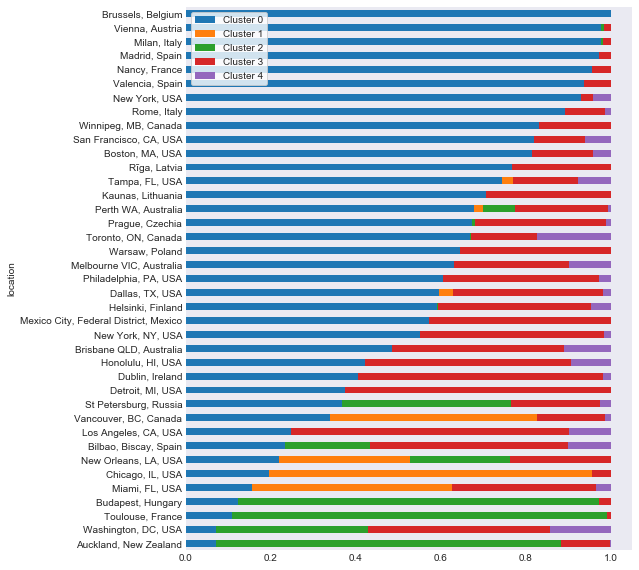

In [81]:
# For all cities:
#prop_clusters.sort_values(by=[('city',0)]).plot(kind='barh', stacked=True, figsize=(15,30), legend=False)

# For the smaller subset:
ax = prop_clusters.loc[subset_cities2['city']].sort_values(by=[('city',0)])\
    .plot(kind='barh', stacked=True, figsize=(8,10), legend=False)

ax.legend( labels=["Cluster {}".format(i) for i in range(n_clusters)], \
          loc="upper left", ncol=1, frameon = True, facecolor="white")

fig = ax.get_figure()

fig.savefig(fname="barh.pdf", bbox_inches='tight')
fig.savefig(fname="../abstract/figures/barh.pdf", bbox_inches='tight')